# 04 - Applied ML

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from operator import itemgetter
from scipy.stats import kstest

from scipy.stats import pareto
from scipy.stats import powerlaw
from scipy.stats import rayleigh

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

We load the dataframe and then proceed to properly categorize the 'race' observed feature as well as converting the married and nodegree variables to printable names.

In [4]:
df = pd.read_csv('lalonde.csv', index_col=[0])

df['race'] = 'white'
df.loc[df['black'] == 1, 'race'] = 'black'
df.loc[df['hispan'] == 1, 'race'] = 'hispanic'
df.drop('black', 1, inplace=True)
df.drop('hispan', 1, inplace=True)
df['race'] = df['race'].astype('category')

df['married'] = df['married'].replace({0: 'Not married', 1: 'Married'}).astype('category')
df['nodegree'] = df['nodegree'].replace({0: 'Degree', 1: 'No degree'}).astype('category')

# Question 1

For each group, we proceed to represent the data by means of the gaussian kernel density estimate and histograms.

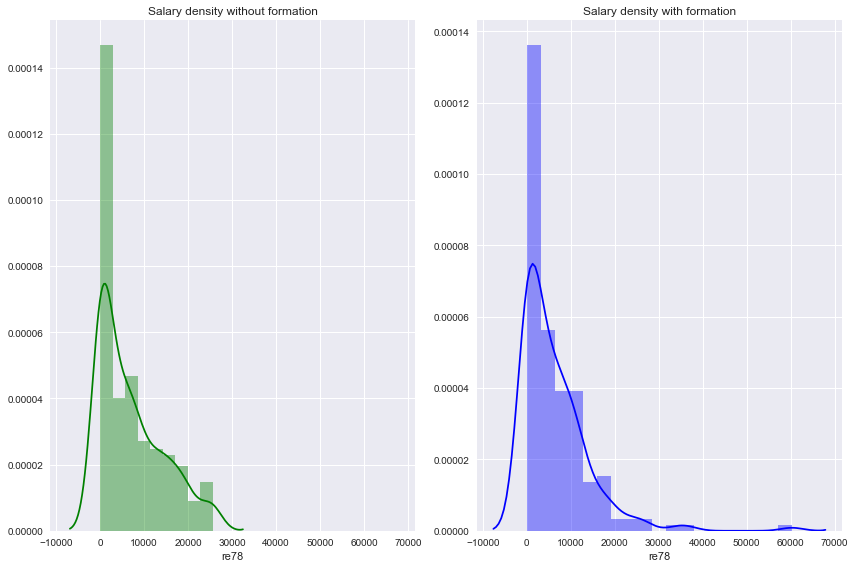

In [5]:
def plot_re78(df):
    treated_res = df[df['treat'] == 1]['re78']
    not_treated_res = df[df['treat'] == 0]['re78']
    f, axes = plt.subplots(1, 2, figsize=(12, 8), sharex=True)
    ax = axes[0]
    ax.set_title("Salary density without formation")
    sns.distplot(not_treated_res, color="g", ax=ax)
    ax = axes[1]
    ax.set_title("Salary density with formation")
    sns.distplot(treated_res, color="b",  ax=ax)
    plt.tight_layout();

plot_re78(df)

The two distribution have a similar shape, this does not give us much information about the effectiveness of the treatment.

We also used a violin plot to have more information. A violin plot is like a boxplot, but is also shows the kernel density estimation on the side.

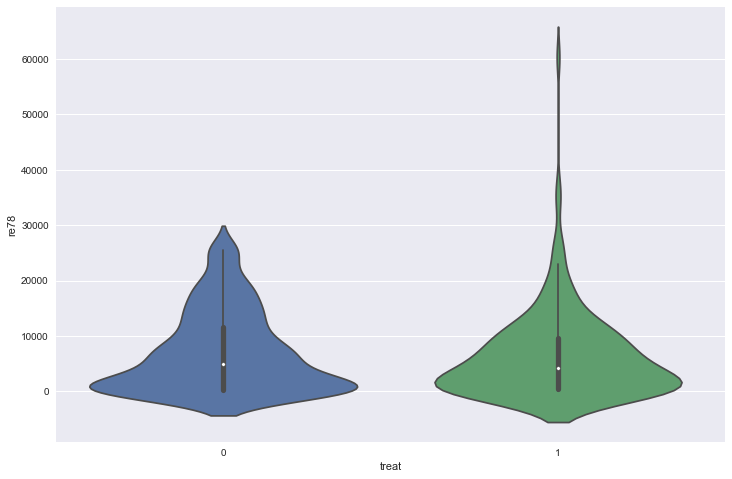

In [12]:
fig, ax = plt.subplots(figsize=(12,8))
sns.violinplot(y='re78',x='treat', data=df, ax=ax);

From these plots, we again see a similar shape in distribution, however, we now see that the median and the interquartile are higher for the not-treated.

Finally, we look at some basic features for each group using pandas "describe".

In [20]:
print("Not treated stats:")
print(df[df['treat'] == 0]['re78'].describe())
print("\nTreated stats:")
print(df[df['treat'] == 1]['re78'].describe())

Not treated stats:
count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64

Treated stats:
count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64


We seee that thhe mean and the median is higher (+600$) for the not-treated.

The naive interpretation suggested by this representation - which assumes that the two groups are comparable and that unobserved variables have no impact on the experiment - is that the treatment, i.e. the formation, has negative impact on the future salary.

In [9]:
print("Treated salary stats:\n" + treated_res.describe().to_string())
print("\nNot treated salary stats:\n" + not_treated_res.describe().to_string())

Treated salary stats:
count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000

Not treated salary stats:
count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000


The first thing that can be noticed is that the number of samples for the two groups is uneven: 185 samples for the treated group against 429 samples for the controlled group. This raises some doubts about the possibility of applying matched observation study. Furthermore, all the statistical metrics are also very different among the groups which doesn't lead us to believe the two groups are really comparable in terms of observed covariates. We will determine the hypothesis at the next point.

# 2

We will use some plots to see the difference of covariates between treated and not treated.

We use violin plots for the not categorical variables, such as age, education and salaries.

We use simple count for the categorical variables.

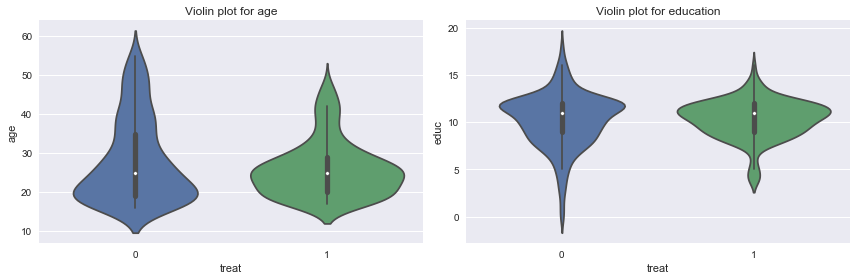

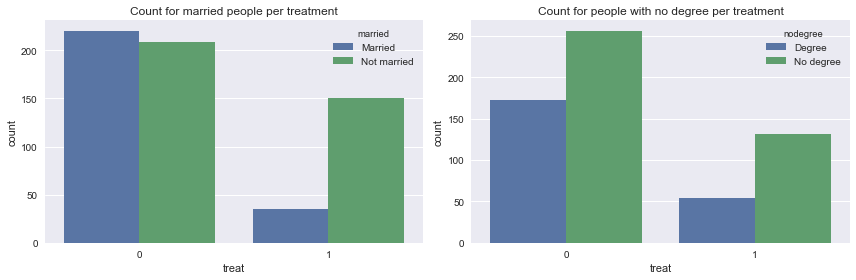

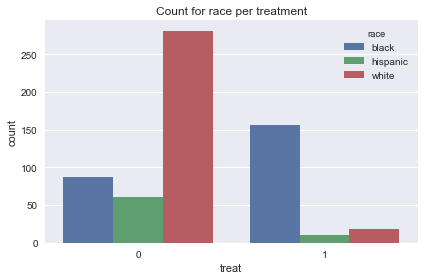

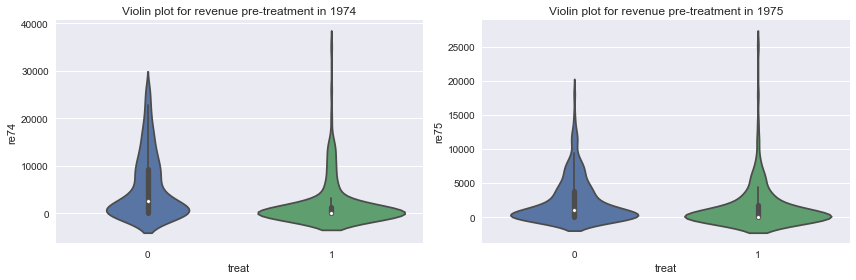

In [145]:
def plot_observed_covariates(df):
    fig, axes = plt.subplots(1,2,figsize=(12,4))

    axes[0].set_title("Violin plot for age")
    sns.violinplot(x='treat', y='age', data=df, ax=axes[0])
    axes[1].set_title("Violin plot for education")
    sns.violinplot(x='treat', y='educ', data=df, ax=axes[1])
    plt.tight_layout()

    fig, axes = plt.subplots(1,2,figsize=(12,4))
    axes[0].set_title("Count for married people per treatment")
    sns.countplot(x='treat',hue='married', data=df, ax=axes[0])
    axes[1].set_title("Count for people with no degree per treatment")
    sns.countplot(x='treat',hue='nodegree', data=df, ax=axes[1])
    plt.tight_layout()

    fig, axes = plt.subplots(1,1,figsize=(6,4))
    axes.set_title("Count for race per treatment")
    sns.countplot(x='treat',hue='race', data=df, ax=axes)
    plt.tight_layout()

    fig, axes = plt.subplots(1,2,figsize=(12,4))
    axes[0].set_title("Violin plot for revenue pre-treatment in 1974")
    sns.violinplot(x='treat', y='re74', data=df, ax=axes[0])
    axes[1].set_title("Violin plot for revenue pre-treatment in 1975")
    sns.violinplot(x='treat', y='re75', data=df, ax=axes[1])
    plt.tight_layout();

plot_observed_covariates(df)

We observe that all the feature distributions are unbalanced among the two groups. 

In order to make sense of an observational study the distributions of the same covariates among the two groups must be similar. This condition allows to affirm that there are similar matched pairs (x,y) - with x element of the treated group and y element of the controlled group - so that if you don't know their treatment assignment a priori, then you have no way to determine it. In others words x and y must have the same probability of having been treated or not. However in our case the distribution for age, marriage, degree, race and pre-treatement is so different among groupes that it is not possible to make this assumption, therefore the naive interpretation of point 1 is totally invalidated.

# 3

We compute the propensity score using a logistic regression for each covariates.

Since we made some variables categorical, we use pandas to transform them in dummies variables. Then we simply fit our logistic regression and the propensity scores are the probabilities of being in the treatment (i.e. second column).

Then we add a propensity column to a copy of our dataframe and compute a violin plot.

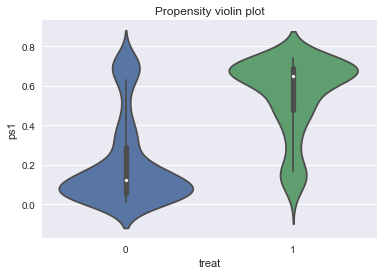

In [23]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()
def compute_propensity(data):
    x = pd.get_dummies(data, columns=['race', 'married', 'nodegree']).drop(['treat', 're78'], 1)
    y = data['treat']
    logistic.fit(x,y)
    return logistic.predict_proba(x)[:,1]

propensity = compute_propensity(df)
df_copy = df.copy()
df_copy['ps1'] = propensity
sns.violinplot(x='treat', y='ps1', data=df_copy)
plt.title("Propensity violin plot");

This visual representation of the propensity score - which is nothing else than the reduction to a single variable of the information associated to the observed covariates - confirm what was said in the previous point: we see the distribution of the propensity score is so unbalanced that based on it the people in the treated group have an high probability of having been treated while those in the controlled group have a very low probability, while for being able to draw conclusions from the data the two distribution should be indistiguishable.
Please note that in this case the propensity score isn't a measure of the probability of beign treated, since the naive model has already been invalidated.

# 4 

The first approach we try is graph based. The idea is to add an edge between all pairs of nodes (x, y) where x belongs to the treated group and y belongs to the controlled group. The weight of the edge between a pair is the absolute difference of the two nodes' propensity.

Rather than using networkx, we noticed that scipy had a function that did exactly what we wanted, i.e. minimum weight matching in bipartite graph. Let $C$ be the cost matrix, where $C_{i,j}$ is the cost of matching the person $i$ with the person $j$. The cost of matching those two person of different group is the absolute difference of propensity. The rows are the treated persons and the columns the not treated.

We simply loop to add the cost, compute the minimum weight matching, create a matched data frame containing all the persons and print the result of the sum of absolute difference.

In [152]:
from scipy.optimize import linear_sum_assignment

propensity = compute_propensity(df)
treated = propensity[df['treat'] == 1]
not_treated = propensity[df['treat'] == 0]

cost = np.zeros((len(treated), len(not_treated)))
for i in range(len(treated)):
    for j in range(len(not_treated)):
        cost[i][j] = np.abs(treated[i]-not_treated[j])
row_ind, col_ind = linear_sum_assignment(cost)
matched = df[df['treat'] == 1].iloc[row_ind].append(df[df['treat'] == 0].iloc[col_ind])
print("Absolute difference sum:", np.sum(np.abs(np.array(treated[row_ind])-np.array(not_treated[col_ind]))))

Absolute difference sum: 31.0260793804


Our first approach is a graph-based one. 
In this graph, people are represented by nodes. The idea is to add an edge between all pairs of nodes (x, y) where x belongs to the treated group and y belongs to the controlled group. The weight of the edge between a pair is the absolute difference of the two nodes' propensity.

Then we simply need to apply a min weight matching algorithm on this graph to get the best matching amond nodes of the two groups. 
Since networkx does not offer a min weight matching function, instead of minimizing the absolute difference of propensity we decided to maximize the opposite of the absolute difference, a different approach yielding the same result.

In [96]:
import networkx as nx
from networkx.algorithms import bipartite

propensity = compute_propensity(df)

G = nx.Graph()
data_copy = df.copy()
propensity = pd.Series(propensity, index=data_copy.index)
treated = propensity[df['treat'] == 1]
not_treated = propensity[df['treat'] == 0]

for index_treated, ps_treated in treated.iteritems():
    G.add_node(index_treated, bipartite=0)
    for index_not_treated, ps_not_treated in not_treated.iteritems():
        G.add_node(index_not_treated, bipartite=1)
        propensity_diff = -np.abs(ps_treated - ps_not_treated)
        G.add_edge(index_treated, index_not_treated, weight=propensity_diff)

In [26]:
graph_matching = nx.max_weight_matching(G, True)

Let's now assest the accuracy of this method. In order to do so, we sum the weight of the nodes between the pairs obtained by applying the max weight matching on our graph and divide by the number of pairs, i.e. compute the average edge weight.

In [138]:
# graph_matching = nx.max_weight_matching(G, True)
propensity = compute_propensity(df)
# data_copy = df.copy()
propensity = pd.Series(propensity, index=df.index)

sum_ = 0
for k, v in {k: v for k, v in graph_matching.items() if 'NSW' in k}.items():
    sum_ += np.abs(propensity.loc[k]-propensity.loc[v])
sum_

31.026079380436407

This value is suspiciously high if we consider the order of magnitude of the propency values. It doesn't hint towards an optimality of the performed matching.

Let's plot the propencies score per group.

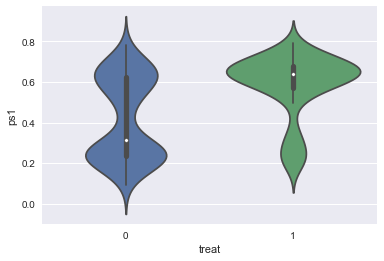

In [122]:
propensity = compute_propensity(matched)
matched['ps1'] = propensity
sns.violinplot(x='treat', y='ps1', data=matched);

We can see that the distribution of the propency score among the two groups is still unbalanced. 
Since this method doesn't seem to yield good results we decided to use another one.

A second approach is using Optimal caliper widths as suggested in https://www.ncbi.nlm.nih.gov/pubmed/20925139.
Our implementation is based on greedy nearest neighbour without replacement and is inspired by http://onlinelibrary.wiley.com/doi/10.1002/sim.6004/epdf.

While computing the matching, we also compute the sum of the accuracy by summing the absolute difference between the nodes' propencies.

In [147]:
from scipy.special import logit
from sklearn.utils import shuffle

def match(data, propensity, seed=1):
    np.random.seed(seed)
    
    caliper = 0.2 * logit(propensity).std()
    data_internal = data.copy()
    data_internal['propensity'] = propensity
    treated = data_internal[data_internal['treat'] == 1]
    not_treated = data_internal[data_internal['treat'] == 0]
    
    matched = treated.copy()
    sum_ = 0
    for idx, propensity in treated['propensity'].iteritems():
        distance = (propensity - not_treated['propensity']).abs()
        min_index = distance.idxmin()
        min_dist = distance.loc[min_index]
        if min_dist < caliper:
            sum_ += min_dist
            matched.loc[len(matched)] = not_treated.loc[min_index]
            not_treated.drop(min_index)
        else:
            print("No Match")
    sum_ /= len(matched)
    return matched, sum_

Let's evaluate the accuracy of this approach. The chosen metric is the average minimal distance among nodes in a pair.

In [148]:
accuracy = match(df, propensity)[1]
accuracy

0.0013241142943866972

It turns out this approach is much more optimal: the average edge weigth is around 100 times smaller than before. We've trouble in finding the reason behind this huge difference. Both method should yield similar results: the causes of the different outcome are probably related to an error in the conceptualization or implementation of the graph-based approach.

Let's use the second approach and plot the new distribution of the propensity scores among groups.

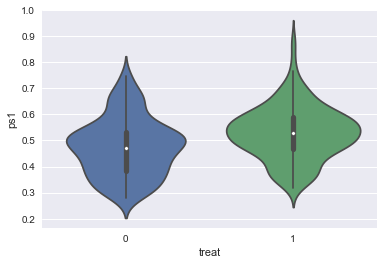

In [149]:
propensity = compute_propensity(df)
matched = match(df, propensity)[0]
propensity = compute_propensity(matched)
matched['ps1'] = propensity
sns.violinplot(x='treat', y='ps1', data=matched);

The improvement compared to the previous plot is visible: while still not exactly the same, the two distribution are now much more similar in shap. The values of the median are also closer than before. 

let's plot the salary density per group.

Not treated stats:
count      185.000000
mean      4667.938810
std       6139.409797
min          0.000000
25%          0.000000
50%        803.883300
75%       7543.794000
max      20243.380000
Name: re78, dtype: float64

Treated stats:
count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64


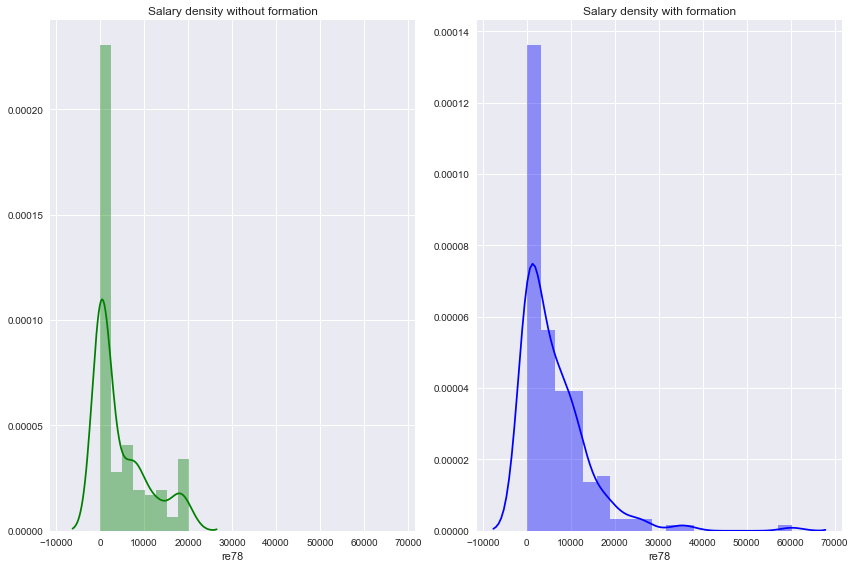

In [150]:
plot_re78(matched)
print("Not treated stats:")
print(matched[matched['treat'] == 0]['re78'].describe())
print("\nTreated stats:")
print(matched[matched['treat'] == 1]['re78'].describe())

These plot are very different from their previous version. A naive interpretation based on the assumption that the naive model is valid would now conclude that taking part in the formation had a positive impact on a partecipant' salary.

Let's plot the distribution of the observed covariates to see if the hypothesis of similarity among treated and controlled group is more respected than before.

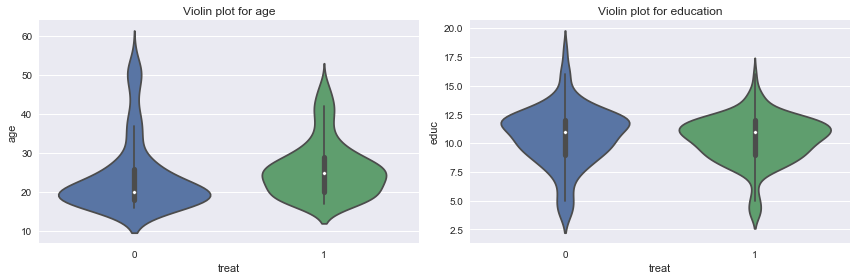

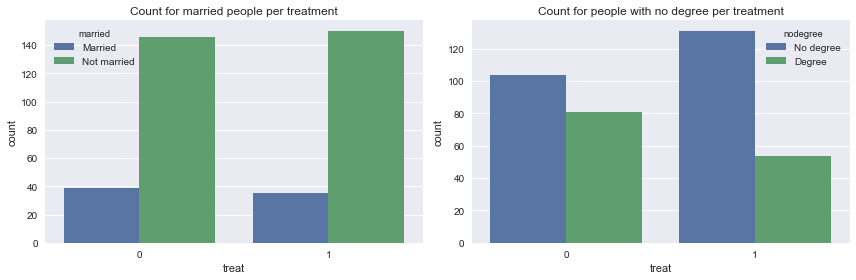

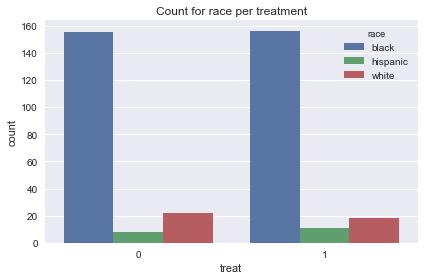

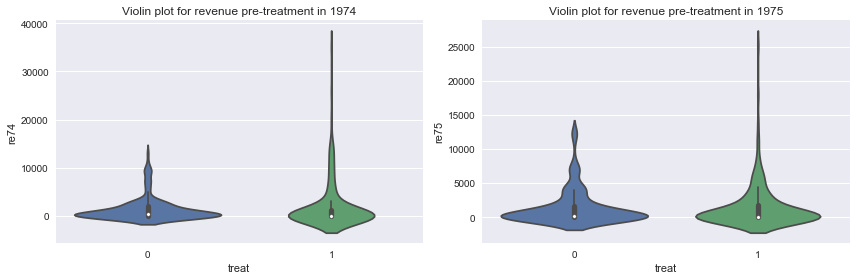

In [151]:
plot_observed_covariates(matched)

We see that indeed the similarity among the two groups has drastically increased. In particular the observed covariates of marriage, degree and race can now be considered extremely balanced, and the others are at least well balanced. The most unbalanced feature is age.

In conclusion, by applying a matching algorithm we're closer to being able to draw conclusion,even if the hypothesis of similarity among groups still isn't perfectly respected.

### Alternate

Let's again plot the distribution and the pandas 'describe' stats.

Not treated stats:
count      185.000000
mean      5562.450366
std       5850.571807
min          0.000000
25%        116.740400
50%       3892.332000
75%       8154.095000
max      20243.380000
Name: re78, dtype: float64

Treated stats:
count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64


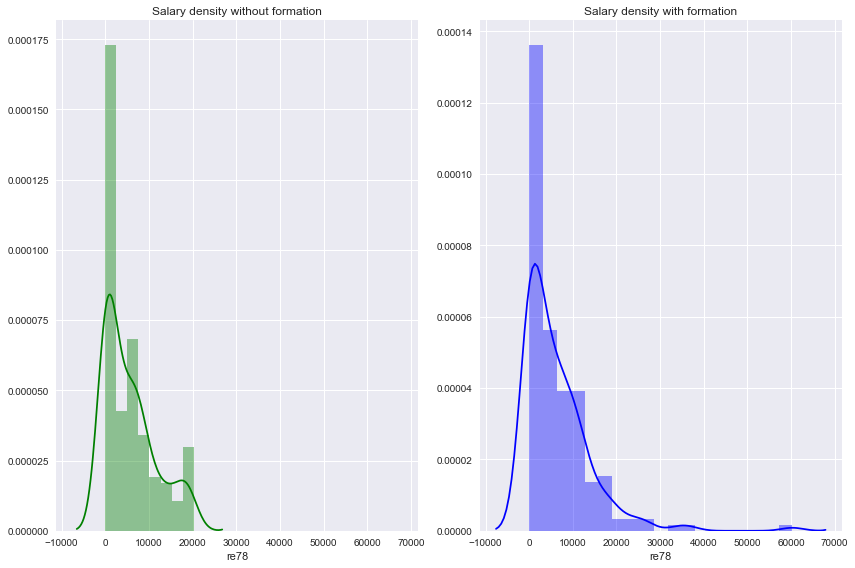

In [153]:
plot_re78(matched)
print("Not treated stats:")
print(matched[matched['treat'] == 0]['re78'].describe())
print("\nTreated stats:")
print(matched[matched['treat'] == 1]['re78'].describe())

These plots and stats are very different from their previous version. A naive interpretation based on the assumption that the naive model is valid would now conclude that taking part in the formation had a positive impact on a participant' salary.

Let's take a look to the covariates.

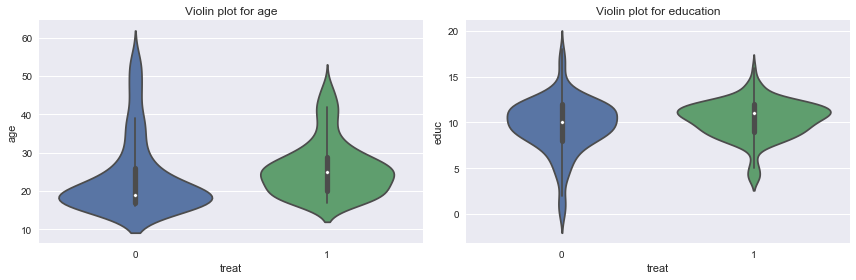

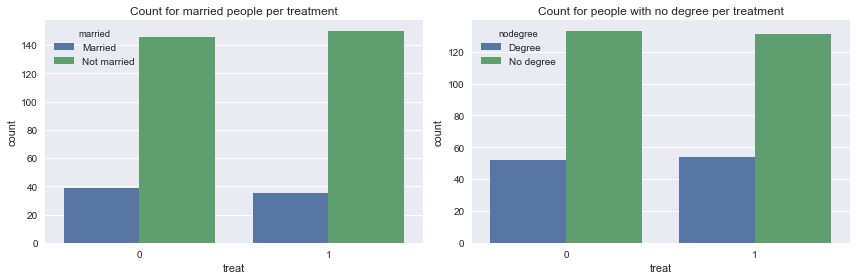

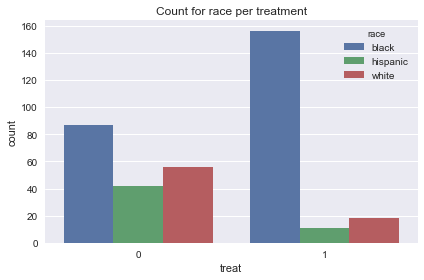

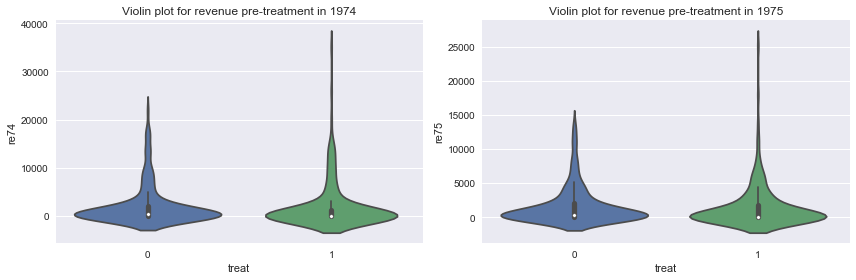

In [154]:
plot_observed_covariates(matched)

Nearly all features are better balanced, except for the ratio of black person, which is much higher in the treated group.

In conclusion, by applying a matching algorithm we're closer to being able to draw conclusion,even if the hypothesis of similarity among groups still isn't perfectly respected.

# 5 

In [230]:
from scipy.special import logit
from sklearn.utils import shuffle

def refined_match(data, propensity, seed=1):
    np.random.seed(seed)
    
    caliper = 0.2 * logit(propensity).std()
    data_internal = data.copy()
    data_internal['propensity'] = propensity
    treated = data_internal[data_internal['treat'] == 1]
    not_treated = data_internal[data_internal['treat'] == 0]
    
    matched = treated.copy()
    sum_ = 0
    for idx, propensity in treated['propensity'].iteritems():
        distance = (propensity - not_treated['propensity']).abs()
        min_index = distance.idxmin()
        min_dist = distance.loc[min_index]
        re75_difference = np.abs(matched.loc[idx]['age'] - not_treated.loc[min_index]['age'])
        if (min_dist < caliper) and (re75_difference < 3):
            sum_ += min_dist
            matched.loc[len(matched)] = not_treated.loc[min_index]
            not_treated.drop(min_index)
    sum_ /= len(matched)
    return matched, sum_

While we think our matching is pretty good as it is, there's still room for improvement. We'll do a refined matching that add constraints related to the most problematic feature, age. In this new matching we add the new condition that in order to be paired two nodes can have a value for age which differs of at most three year. This should improve the quality of the matching while reducing the dataset size.

First of all let's plot the accuracy metric - average edge weigth among nodes in a pair - to see if there's really an improvement.

In [231]:
propensity = compute_propensity(df)
finely_matched, accuracy = refined_match(df, propensity)
accuracy

0.00058364474225631991

There's indeed an improvement of factor 10, i.e. the edge weight is on average 10 times smaller.

Now let's plot the features one last time.

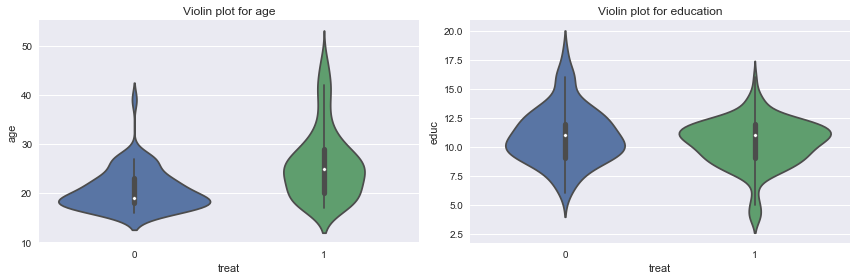

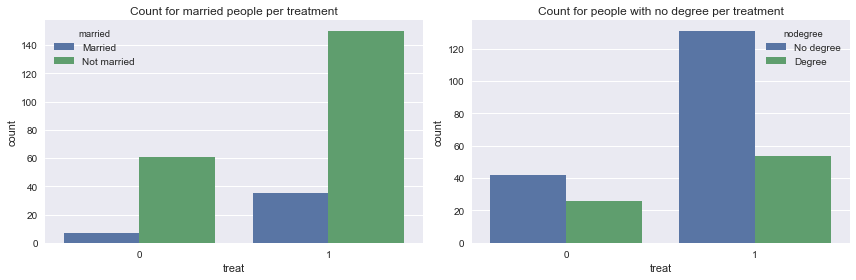

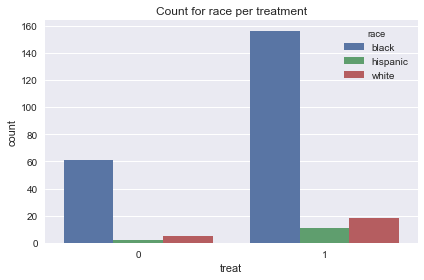

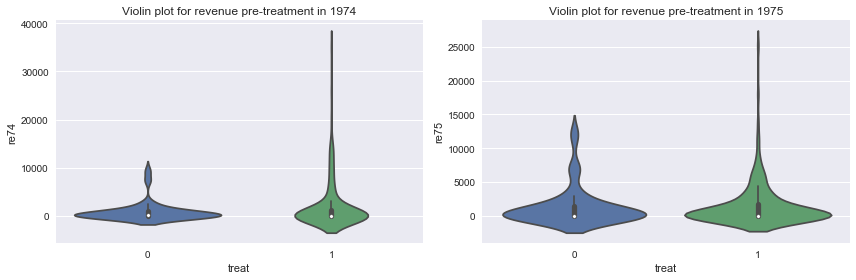

In [232]:
plot_observed_covariates(finely_matched)

The improvement is hard to see for the naked eye, so we can base ourselves only on our accuracy metric.

### Alternate

In [218]:
from scipy.optimize import linear_sum_assignment

propensity = compute_propensity(df)

propensity_not_black = propensity[df['race'] != 'black']
df_not_black = df[df['race'] != 'black']

treated = propensity_not_black[df_not_black['treat'] == 1]
not_treated = propensity_not_black[df_not_black['treat'] == 0]

cost = np.zeros((len(treated), len(not_treated)))
for i in range(len(treated)):
    for j in range(len(not_treated)):
        cost[i][j] = np.abs(treated[i]-not_treated[j])
row_ind, col_ind = linear_sum_assignment(cost)
matched_not_black = df_not_black[df_not_black['treat'] == 1].iloc[row_ind].append(df_not_black[df_not_black['treat'] == 0].iloc[col_ind])
print("Absolute difference sum:", np.sum(np.abs(np.array(treated[row_ind])-np.array(not_treated[col_ind]))))


propensity_black = propensity[df['race'] == 'black']
df_black = df[df['race'] == 'black']

treated = propensity_black[df_black['treat'] == 1]
not_treated = propensity_black[df_black['treat'] == 0]

cost = np.zeros((len(not_treated), len(treated)))
for i in range(len(not_treated)):
    for j in range(len(treated)):
        cost[i][j] = np.abs(not_treated[i]-treated[j])
row_ind, col_ind = linear_sum_assignment(cost)
matched_black = df_black[df_black['treat'] == 0].iloc[row_ind].append(df_black[df_black['treat'] == 1].iloc[col_ind])
print("Absolute difference sum:", np.sum(np.abs(np.array(not_treated[row_ind])-np.array(treated[col_ind]))))

Absolute difference sum: 0.0285369801375
Absolute difference sum: 1.46014322264


In [222]:
matched = matched_black.append(matched_not_black)

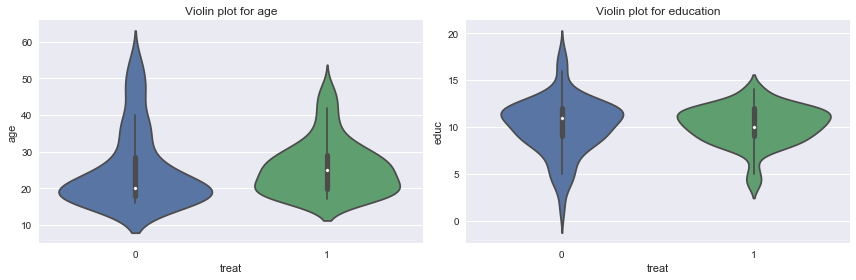

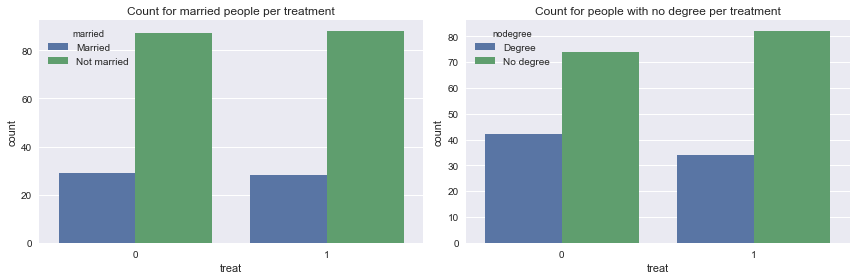

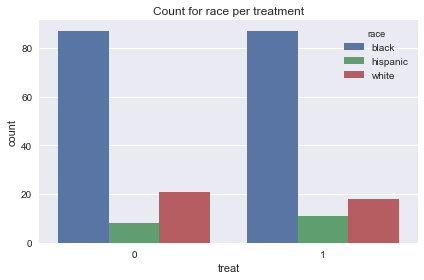

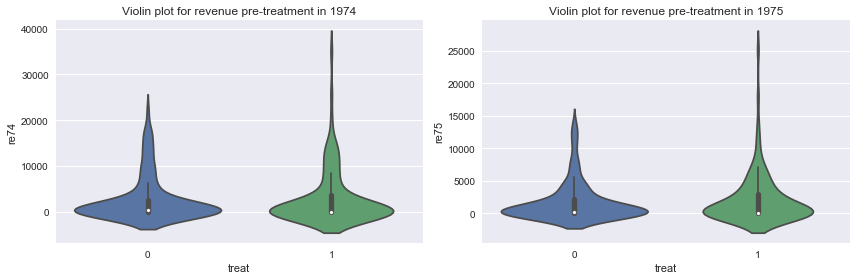

In [223]:
plot_observed_covariates(matched)

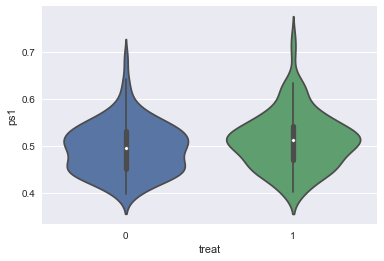

In [224]:
propensity = compute_propensity(matched)
matched['ps1'] = propensity
sns.violinplot(x='treat', y='ps1', data=matched);

# 6 

Not treated stats:
count       68.00000
mean      5039.80845
std       6195.11484
min          0.00000
25%         87.55530
50%       1613.67700
75%       7597.73100
max      20243.38000
Name: re78, dtype: float64

Treated stats:
count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64


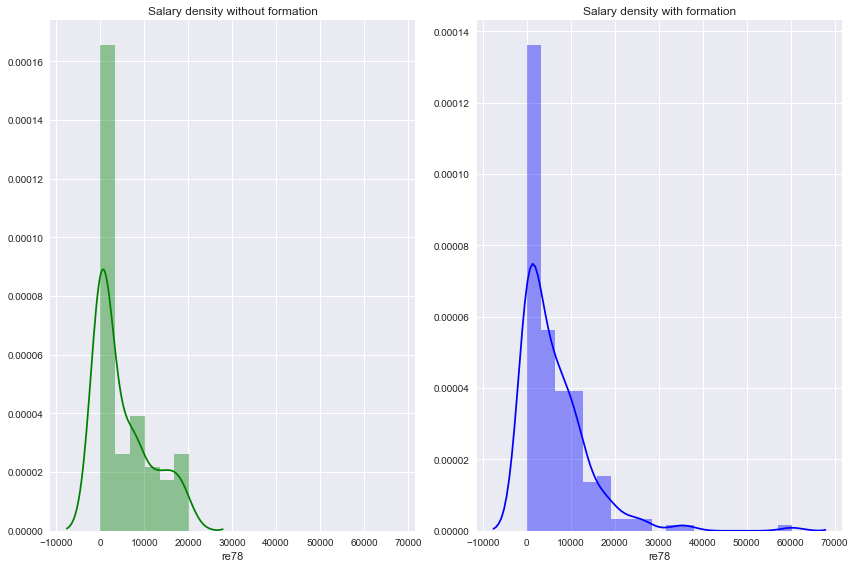

In [233]:
print("Not treated stats:")
print(finely_matched[finely_matched['treat'] == 0]['re78'].describe())
print("\nTreated stats:")
print(finely_matched[finely_matched['treat'] == 1]['re78'].describe())
plot_re78(finely_matched)

Now that we've done the best to balance our observed covariates, we must accept that we're as close as we can to respecting the similarity hypothesis. With this in mind and assuming the unobserved covariates have no influence on the experiment, we can use the naive model to affirm that the formation has a positive impact on the perceived salary of the people who undertake it, since the salary density for these people is centered around much higher values.

### Alternate

Not treated stats:
count      116.000000
mean      4918.268981
std       5837.783605
min          0.000000
25%          0.000000
50%       2283.087500
75%       7512.762250
max      20243.380000
Name: re78, dtype: float64

Treated stats:
count      116.000000
mean      6936.833122
std       8235.716573
min          0.000000
25%        725.969275
50%       5336.144500
75%       9940.204750
max      60307.930000
Name: re78, dtype: float64


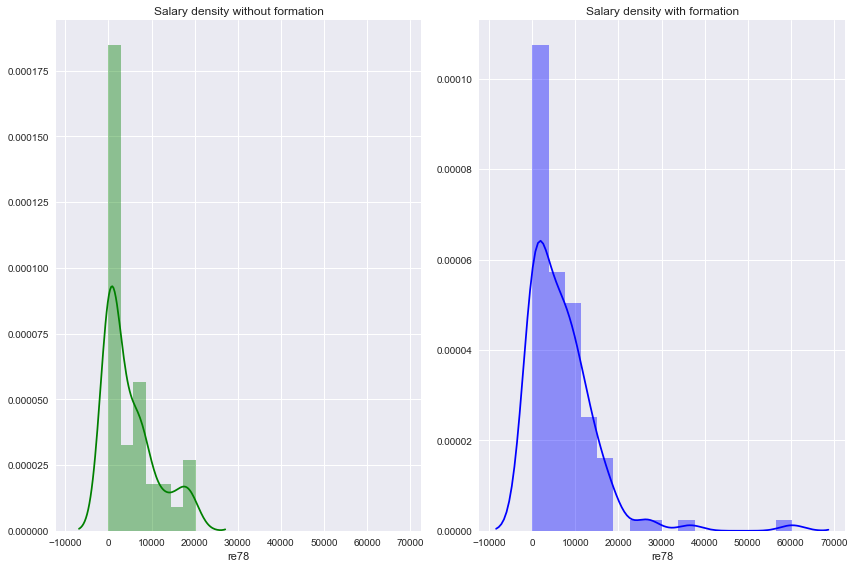

In [226]:
print("Not treated stats:")
print(matched[matched['treat'] == 0]['re78'].describe())
print("\nTreated stats:")
print(matched[matched['treat'] == 1]['re78'].describe())
plot_re78(matched)